In [1]:
import as_seg.scripts.default_path as paths
import as_seg.scripts.overall_scripts as scr
import as_seg.data_manipulation as dm
import as_seg.CBM_algorithm as CBM
import as_seg.autosimilarity_computation as as_comp
import as_seg.barwise_input as bi
from as_seg.model.current_plot import *

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl

In [2]:
colors = ['tab:green', 'tab:purple','tab:red','tab:olive']
markers = ['^', 's', 'o','v']

bands_numbers = [None, 3, 7, 15]
autosimilarity_types = ["Cosine", "Covariance", "RBF"]
penalty_function = "modulo8"#["Nope", "modulo_oracle_salami"]
bands_numbers_labels = ["Full kernel", "3-bands kernel", "7-bands kernel", "15-bands kernel"]#["Nope", "modulo_oracle_salami"]
#penalty_functions_target =  ["Nope", "target_deviation_8_alpha_half", "target_deviation_8_alpha_one", "target_deviation_8_alpha_two"]#["Nope", "modulo_oracle_salami"]
feature = "log_mel_grill"

lambda_range = np.concatenate([np.arange(0.1, 2.1, 0.1)])

In [3]:
def learn_and_test_salami(lambda_range, feature = "log_mel_grill", autosimilarity_type = "cosine", bands_number = 15, penalty_func = "modulo8"):
    """
    Learning the latent space dimension on the non-test subset of the SALAMI dataset, and computes the results on the SALAMI test-dataset.
    """
    salami = mirdata.initialize('salami', data_home = paths.path_entire_salami)
    len_salami = len(salami.track_ids)
    
    results_songs_lambdas = -math.inf * np.ones((len_salami, len(lambda_range), 2, 3))
    lengths_all_lambda = []
    for i in range(len(lambda_range)):
        lengths_all_lambda.append([])
        
    hop_length = 32
    hop_length_seconds = hop_length/44100
    subdivision_bars = 96
    
    all_tracks = salami.load_tracks()    
    song_idx = 0
    file_mirex = open(f"{os.getcwd()}/test_set_salami_gs.txt")

    test_dataset = []
    for part in file_mirex.readlines():
        line_broken = part.split("\n")
        test_dataset.append(int(line_broken[0]))
            
    for key, track in all_tracks.items():
        if int(key) not in test_dataset: # Every other file than the test dataset
            try:
                bars = scr.load_or_save_bars(paths.path_data_persisted_salami, track.audio_path)
                tensor_barwise = scr.load_or_save_tensor_spectrogram(paths.path_data_persisted_salami, track.audio_path, feature, hop_length, subdivision_bars)
                barwise_TF_matrix = tl.unfold(tensor_barwise, 0)
                              
                ref_tab = []
                try:
                    references_segments = salami.load_sections(track.sections_annotator1_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass

                try:
                    references_segments = salami.load_sections(track.sections_annotator2_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass
                try:
                    autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
                    for idx_lambda, lambda_penalty in enumerate(lambda_range):
                        segments = CBM.compute_cbm(autosimilarity_barTF_matrix, penalty_weight = lambda_penalty, penalty_func = penalty_func, bands_number = bands_number)[0]                
                        segments_in_time = dm.segments_from_bar_to_time(segments, bars)
                        for end, start in segments:
                            lengths_all_lambda[idx_lambda].append(start - end)
                        prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 0.5)
                        prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 3)
                        this_score = [[round(prec05,4),round(rap05,4),round(f_mes05,4)], [round(prec3,4),round(rap3,4),round(f_mes3,4)]]

                        if len(ref_tab) > 1:
                            nd_prec05, nd_rap05, nd_f_mes05 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 0.5)
                            nd_prec3, nd_rap3, nd_f_mes3 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 3)
                            if nd_f_mes05 + nd_f_mes3 > f_mes05 + f_mes3:
                                this_score = [[round(nd_prec05,4),round(nd_rap05,4),round(nd_f_mes05,4)], [round(nd_prec3,4),round(nd_rap3,4),round(nd_f_mes3,4)]]
                        results_songs_lambdas[song_idx, idx_lambda] = np.array(this_score)
                    song_idx += 1
                except TypeError:
                    print(f"Error in learning at song {key}, {track}")
                
            except FileNotFoundError:
                print(f"{key} not found, normal ?")
                
    #for idx_lambda, lambda_penalty in enumerate(lambda_range):
        #print(lambda_penalty)
        #plot_lenghts_hist(lengths_all_lambda[idx_lambda])

    avg_songs = [np.mean(results_songs_lambdas[:song_idx, i, 0, 2]) + np.mean(results_songs_lambdas[:song_idx, i, 1, 2]) for i in range(len(lambda_range))]
    best_lambda_idx = np.argmax(avg_songs)
    print(f"Best lambda: {lambda_range[best_lambda_idx]}")

    return fixed_conditions_results_salami(lambda_range[best_lambda_idx], feature = feature, autosimilarity_type = autosimilarity_type, bands_number = bands_number, penalty_func = penalty_func)    

def fixed_conditions_results_salami(lambda_penalty, feature = "log_mel_grill", autosimilarity_type = "cosine", bands_number = 15, penalty_func = "modulo8"):
    salami = mirdata.initialize('salami', data_home = paths.path_entire_salami)
    len_salami = len(salami.track_ids)
    lengths = []
    results = -math.inf * np.ones((len_salami, 2, 3))
    
    hop_length = 32
    hop_length_seconds = hop_length/44100
    subdivision_bars = 96
    
    all_tracks = salami.load_tracks()
    
    song_idx = 0
    
    file_test_set_gs = open(f"{os.getcwd()}/test_set_salami_gs.txt")

    test_dataset = []
    for part in file_test_set_gs.readlines():
        line_broken = part.split("\n")
        test_dataset.append(int(line_broken[0]))

    for key, track in all_tracks.items():
        if int(key) in test_dataset:
            try:               
                bars = scr.load_or_save_bars(paths.path_data_persisted_salami, track.audio_path)
                tensor_barwise = scr.load_or_save_tensor_spectrogram(paths.path_data_persisted_salami, track.audio_path, feature, hop_length, subdivision_bars)
                barwise_TF_matrix = tl.unfold(tensor_barwise, 0)
  
                ref_tab = []
                try:
                    references_segments = salami.load_sections(track.sections_annotator1_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass
                    
                try:
                    references_segments = salami.load_sections(track.sections_annotator2_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass
                try:
                    autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
                    segments = CBM.compute_cbm(autosimilarity_barTF_matrix, penalty_weight = lambda_penalty, penalty_func = penalty_func, bands_number = bands_number)[0]                
                    segments_in_time = dm.segments_from_bar_to_time(segments, bars)
                    for end, start in segments:
                        lengths.append(start - end)

                    prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 0.5)
                    prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 3)
                    this_score = [[round(prec05,4),round(rap05,4),round(f_mes05,4)], [round(prec3,4),round(rap3,4),round(f_mes3,4)]]

                    if len(ref_tab) > 1:
                        nd_prec05, nd_rap05, nd_f_mes05 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 0.5)
                        nd_prec3, nd_rap3, nd_f_mes3 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 3)
                        if nd_f_mes05 + nd_f_mes3 > f_mes05 + f_mes3:
                            this_score = [[round(nd_prec05,4),round(nd_rap05,4),round(nd_f_mes05,4)], [round(nd_prec3,4),round(nd_rap3,4),round(nd_f_mes3,4)]]
                    results[song_idx] = np.array(this_score)
                    song_idx += 1
                except TypeError:
                    print(f"Error in test at song {key}, {track}")
    
            except FileNotFoundError:
                print(f"{key} not found, normal ?")

    print(f"Tested on {song_idx} songs")
    lines = np.array(["Precision 0.5", "Recall 0.5", "F measure 0.5","Precision 3", "Recall 3", "F measure 3"])  
    results_cropped = results[:song_idx]
    #display(pd.DataFrame([round(np.mean(results_cropped[:,0, 0]),5), round(np.mean(results_cropped[:, 0,1]),5), round(np.mean(results_cropped[:, 0,2]),5), round(np.mean(results_cropped[:,1, 0]),5), round(np.mean(results_cropped[:, 1,1]),5), round(np.mean(results_cropped[:, 1,2]),5)], columns=["Barwise FT"], index=lines).T)
    return np.array([[round(np.mean(results_cropped[:,0, 0]),5), round(np.mean(results_cropped[:, 0,1]),5), round(np.mean(results_cropped[:, 0,2]),5)], [round(np.mean(results_cropped[:,1, 0]),5), round(np.mean(results_cropped[:, 1,1]),5), round(np.mean(results_cropped[:, 1,2]),5)]])

def get_segment_sizes_repartition_from_autosimilarity_penalty_arg(autosimilarity, bars, references_segments, penalty_func, lambda_penalty, bands_number = 15):
    lengths = []
    segments = CBM.compute_cbm(autosimilarity, penalty_weight = lambda_penalty, penalty_func = penalty_func, bands_number = bands_number)[0]                
    for end, start in segments:
        lengths.append(start - end)
    print(lengths)
    return lengths

In [7]:
def plot_kernels_as(results_diff_as, kernels_or_features, autosimilarities, tol, title = None):
    # Order results_diff_as: kernels ou features, as, tol
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 15})
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    colors = ["#62d5b4", "#317373", "#184a4a"]#['skyblue', 'steelblue', 'darkorange', 'brown']
    
    fig, ax = plt.subplots(1, 1, figsize=(11,3))
    ax.set_ylim( 20,90)
    tab = []
    current_start = 0
    for i in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels_or_features))]
        tab.append(ax.bar(indexes, results_diff_as[:,i,tol], color=colors[i], width=width, align='edge'))
        for idx_x, x in enumerate(indexes):
            height = results_diff_as[idx_x, i, tol] 
            plt.text(x +width/2,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2 + j*gap for j in range(len(kernels_or_features))])
    ax.set_xticklabels(kernels_or_features)
    if tol == 1:
        ax.legend(labels=subaxis, loc='lower left', ncol = 3)

    else:
        ax.legend(labels=subaxis, loc='upper left', ncol = 3)

    ax.set_ylabel("F measure (percentage)")

    fig.savefig(f"results_barcomp_salami_{tol}.pdf", bbox_inches = "tight")#, format='png')
    if title != None:
        plt.title(title)
    plt.show()

Kernel: None
Autosimilarity type: Cosine
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 0.1
70 not found, normal ?
Tested on 486 songs
Autosimilarity type: Covariance
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 1.4000000000000001
70 not found, normal ?
Tested on 486 songs
Autosimilarity type: RBF
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 0.1
70 not found, normal ?
Tested on 486 songs


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.470270,0.334750,0.381130,0.650100,0.461440,0.526160
Autosimilarity: Covariance,0.380830,0.538460,0.433050,0.546830,0.778150,0.623260
Autosimilarity: RBF,0.456670,0.461940,0.445460,0.635220,0.647780,0.622190


Kernel: 3
Autosimilarity type: Cosine
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 0.1
70 not found, normal ?
Tested on 486 songs
Autosimilarity type: Covariance
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 2.0
70 not found, normal ?
Tested on 486 songs
Autosimilarity type: RBF
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 0.30000000000000004
70 not found, normal ?
Tested on 486 songs


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.214670,0.516210,0.292290,0.346440,0.844780,0.474430
Autosimilarity: Covariance,0.270330,0.563250,0.353010,0.403310,0.843190,0.527340
Autosimilarity: RBF,0.242310,0.589570,0.331980,0.361820,0.889690,0.497420


Kernel: 7
Autosimilarity type: Cosine
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 0.1
70 not found, normal ?
Tested on 486 songs
Autosimilarity type: Covariance
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 1.2000000000000002
70 not found, normal ?
Tested on 486 songs
Autosimilarity type: RBF
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 0.1
70 not found, normal ?
Tested on 486 songs


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.295160,0.426810,0.337170,0.460060,0.665300,0.525970
Autosimilarity: Covariance,0.336170,0.572210,0.411140,0.482490,0.827250,0.591720
Autosimilarity: RBF,0.356900,0.555080,0.421690,0.511780,0.803920,0.606890


Kernel: 15
Autosimilarity type: Cosine
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 0.1
70 not found, normal ?
Tested on 486 songs
Autosimilarity type: Covariance
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 1.2000000000000002
70 not found, normal ?
Tested on 486 songs
Autosimilarity type: RBF
710 not found, normal ?
716 not found, normal ?


C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


932 not found, normal ?
1248 not found, normal ?
722 not found, normal ?
720 not found, normal ?
711 not found, normal ?
718 not found, normal ?
717 not found, normal ?
63 not found, normal ?
719 not found, normal ?
714 not found, normal ?
709 not found, normal ?
261 not found, normal ?
724 not found, normal ?
878 not found, normal ?
712 not found, normal ?
715 not found, normal ?
723 not found, normal ?
Best lambda: 0.2
70 not found, normal ?
Tested on 486 songs


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.377280,0.365990,0.360400,0.542850,0.523590,0.517250
Autosimilarity: Covariance,0.370570,0.556350,0.432240,0.528910,0.799600,0.618490
Autosimilarity: RBF,0.425590,0.502960,0.449400,0.596590,0.709880,0.631810


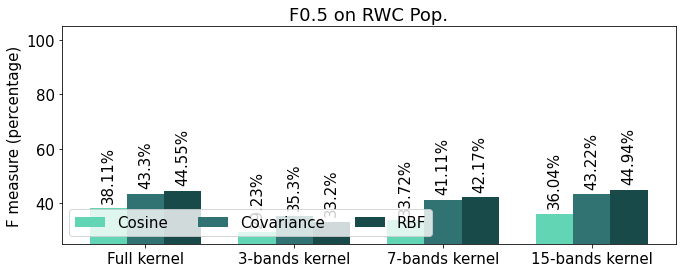

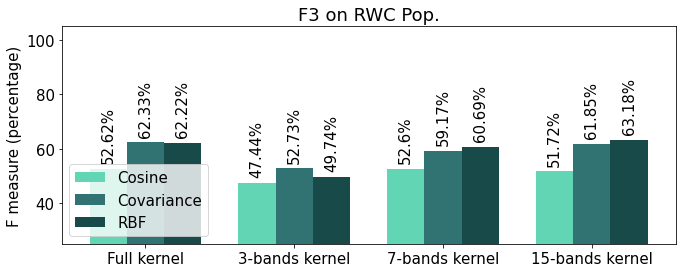

In [5]:
res_avg_target = math.inf * np.ones((len(bands_numbers), len(autosimilarity_types), 2, 3))

for idx_b, bands_number in enumerate(bands_numbers):
    print(f"Kernel: {bands_number}")
    
    indexes = []
    results_this_function = math.inf * np.ones((len(autosimilarity_types), 2, 3))
    for idx_as, autosimil_type in enumerate(autosimilarity_types):
        print(f"Autosimilarity type: {autosimil_type}")
        res = learn_and_test_salami(lambda_range, feature = "log_mel_grill", autosimilarity_type = autosimil_type, bands_number = bands_number, penalty_func = penalty_function)
        results_this_function[idx_as] = res
        indexes.append(f"Autosimilarity: {autosimil_type}")
    res_avg_target[idx_b] = results_this_function
    dataframe = pd.DataFrame(results_this_function.reshape(results_this_function.shape[0], 6), columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = indexes)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), bands_numbers_labels, autosimilarity_types, 0, title = f"F0.5 on RWC Pop.")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), bands_numbers_labels, autosimilarity_types, 1, title = f"F3 on RWC Pop.")


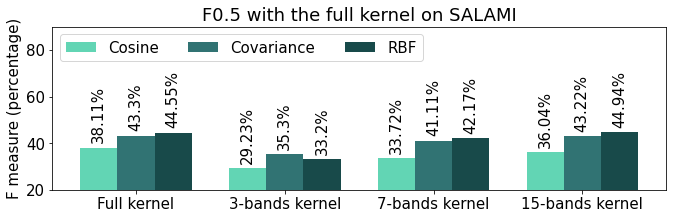

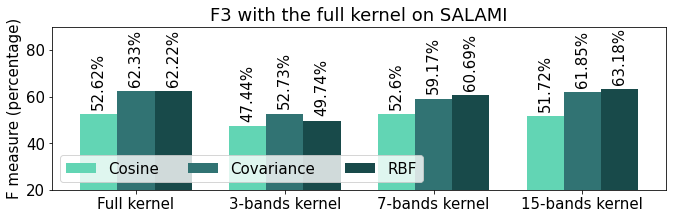

In [9]:
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), bands_numbers_labels, autosimilarity_types, 0, title = f"F0.5 with the full kernel on SALAMI")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), bands_numbers_labels, autosimilarity_types, 1, title = f"F3 with the full kernel on SALAMI")